**Download the datasets**

In [1]:
import yfinance as yf # 資料來源： Yahoo Finance
import numpy as np

# Define USD-based currency pairs to download (Yahoo Finance ticker format)
symbols = ['USDJPY=X', 'EURUSD=X', 'GBPUSD=X']

# Download historical FX data
fx_data = {}
for symbol in symbols:
    data = yf.download(symbol, period="6y", interval="1d")
    fx_data[symbol] = data['Close']
    print(f"{symbol} - {len(data)} rows downloaded.")

# Convert to pure numpy arrays
fx_numpy_list = [fx_data[s].to_numpy() for s in symbols]

# Align all currency pairs to the same length
min_len = min(len(arr) for arr in fx_numpy_list)
fx_numpy_list = [arr[-min_len:] for arr in fx_numpy_list]

# Combine into shape (3, N) → each currency pair is one row (dimension)
fx_combined = np.stack(fx_numpy_list, axis=0)
fx_data = fx_combined.reshape(3, -1)

C:\Users\HP\AppData\Local\Temp\ipykernel_1364\1995630283.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, period="6y", interval="1d")
[*********************100%***********************]  1 of 1 completed
C:\Users\HP\AppData\Local\Temp\ipykernel_1364\1995630283.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, period="6y", interval="1d")


USDJPY=X - 1563 rows downloaded.


[*********************100%***********************]  1 of 1 completed
C:\Users\HP\AppData\Local\Temp\ipykernel_1364\1995630283.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, period="6y", interval="1d")


EURUSD=X - 1563 rows downloaded.


[*********************100%***********************]  1 of 1 completed

GBPUSD=X - 1563 rows downloaded.


In [2]:
import pandas as pd

# Transpose → shape becomes (N, 3), suitable for DataFrame format
fx_data = fx_data.T  # Example: shape (N, 3), N = number of days

# Define currency pair column names (without "=X" for cleaner column names)
symbols = ['USDJPY', 'EURUSD', 'GBPUSD']

# Convert to DataFrame
df = pd.DataFrame(fx_data, columns=symbols)

# Save to Excel
df.to_excel('fx_data.xlsx', index=False)

print("Saved to fx_data.xlsx")

Saved to fx_data.xlsx


**Train Process**

***Step 1：切訓練集 + 測試集（預測 horizon = 1***

In [3]:
# 自動依照比例切分訓練集與測試集
from sklearn.preprocessing import MinMaxScaler

# Step 1: 檢查資料長度
num_days = fx_data.shape[0]
print(f"共有 {num_days} 天的資料")

# Step 2: 切分比例（例如：80% 訓練）
train_ratio = 0.8
train_days = int(num_days * train_ratio)
print(f"訓練集長度: {train_days} 天")
print(f"測試集長度: {num_days - train_days} 天")

# Step 3: 正規化資料
scaler = MinMaxScaler()
fx_scaled = scaler.fit_transform(fx_data)  # shape: (N, 3)

# Step 4: 切出訓練集
window_size = 30
X_train, y_train = [], []
for i in range(train_days - window_size):
    X_train.append(fx_scaled[i:i+window_size])
    y_train.append(fx_scaled[i+window_size])
X_train = np.array(X_train)
y_train = np.array(y_train)


共有 1563 天的資料
訓練集長度: 1250 天
測試集長度: 313 天


*** Step 2：建立並訓練模型（用 LSTM 為例***

Epoch 1/100


c:\Users\HP\anaconda3\envs\mll\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2110 - val_loss: 0.0645
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0217 - val_loss: 0.0334
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - val_loss: 0.0124
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - val_loss: 0.0052
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - val_

模型已儲存為 fx_model_gru.h5


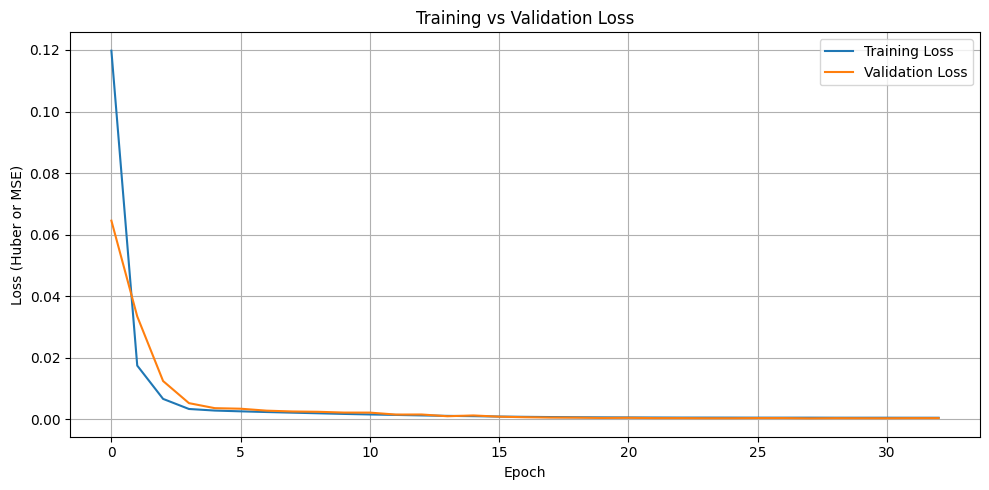

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# 建立 GRU 模型
model = Sequential()
model.add(GRU(32, input_shape=(window_size, 3)))
model.add(Dense(3))  # 三個幣種輸出
model.compile(optimizer='adam', loss='mse')

# 訓練
history = model.fit(
    X_train, y_train,
    validation_split=0.1,  # ← 加上驗證集
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# 儲存完整模型
model.save("fx_model_gru.h5")
print("模型已儲存為 fx_model_gru.h5")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber or MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/loss_curve.png")
plt.show()


***Step 3：開始做 Rolling 預測 + 驗證***

In [5]:
# 用訓練完的模型，從 day=1000 到 day=1089 做逐日預測
preds = []
true_vals = []

for i in range(train_days, len(fx_scaled) - 1):
    input_seq = fx_scaled[i - window_size:i]  # 拿前30天做預測
    input_seq = input_seq.reshape(1, window_size, 3)

    pred_scaled = model.predict(input_seq)[0]  # shape: (3,)
    true_scaled = fx_scaled[i]  # 真實第 i 天的資料

    # 還原成實際價格
    pred_real = scaler.inverse_transform([pred_scaled])[0]
    true_real = scaler.inverse_transform([true_scaled])[0]

    preds.append(pred_real)
    true_vals.append(true_real)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

***Step 4：計算誤差指標（RMSE、MAE)***

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

preds = np.array(preds)
true_vals = np.array(true_vals)

rmse = np.sqrt(mean_squared_error(true_vals, preds))
mae = mean_absolute_error(true_vals, preds)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


RMSE: 0.7156
MAE: 0.3274


In [7]:
import matplotlib.pyplot as plt
import os

currency_names = ['USDJPY', 'EURUSD', 'GBPUSD']

# 建立 results 資料夾（若尚未存在）
save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)

def get_unique_filename(base_name, ext='png'):
    """回傳不重複的檔案名稱（在 results 資料夾內）"""
    counter = 1
    filename = os.path.join(save_dir, f"{base_name}.{ext}")
    while os.path.exists(filename):
        filename = os.path.join(save_dir, f"{base_name}_{counter}.{ext}")
        counter += 1
    return filename

for i in range(3):
    plt.figure(figsize=(10, 4))
    plt.plot([t[i] for t in true_vals], label='True')
    plt.plot([p[i] for p in preds], label='Predicted')
    plt.title(f"Rolling Prediction - {currency_names[i]}")
    plt.xlabel("Days")
    plt.ylabel("Exchange Rate")
    plt.legend()
    plt.grid(True)

    filename = get_unique_filename(f"rolling_prediction_{currency_names[i]}")
    plt.savefig(filename)
    plt.close()
    print(f"Saved: {filename}")


Saved: results\rolling_prediction_USDJPY_14.png
Saved: results\rolling_prediction_EURUSD_14.png
Saved: results\rolling_prediction_GBPUSD_14.png
